In [2]:
import pandas as pd
import numpy as np
from datetime import timedelta
import random
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
goog_data = pd.read_csv('GOOG.csv')
crm_data = pd.read_csv('CRM.csv')
hpe_data = pd.read_csv('HPE.csv')
insider_data = pd.read_csv('insiderdata.csv')

In [4]:
# Convert 'Date' columns to datetime format
goog_data['Date'] = pd.to_datetime(goog_data['Date'], format='%Y-%m-%d')
crm_data['Date'] = pd.to_datetime(crm_data['Date'], format='%Y-%m-%d')
hpe_data['Date'] = pd.to_datetime(hpe_data['Date'], format='%Y-%m-%d')
insider_data['Transaction Date'] = pd.to_datetime(insider_data['Transaction Date'], format='%m/%d/%Y')


print("GOOG Stock Data:")
print(goog_data.head(), "\n")

print("Insider Trades Data:")
print(insider_data.head())

# Filter insider trades to include only GOOG, CRM, and HPE
filtered_trades = insider_data[insider_data['Issuer Trading Symbol'].isin(['GOOG', 'CRM', 'HPE'])]

# Check how many trades are found for each stock
for symbol in ['GOOG', 'CRM', 'HPE']:
    print(f"Number of {symbol} insider trades: {len(filtered_trades[filtered_trades['Issuer Trading Symbol'] == symbol])}")

GOOG Stock Data:
        Date       Open       High        Low      Close    Volume  Dividends  \
0 2004-08-19  49.813290  51.835709  47.800831  49.982655  44871361          0   
1 2004-08-20  50.316402  54.336334  50.062355  53.952770  22942874          0   
2 2004-08-23  55.168217  56.528118  54.321388  54.495735  18342897          0   
3 2004-08-24  55.412300  55.591629  51.591621  52.239197  15319808          0   
4 2004-08-25  52.284027  53.798351  51.746044  52.802086   9232276          0   

   Stock Splits  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0   

Insider Trades Data:
   Unnamed: 0.1  Unnamed: 0 Buy/Sell Transaction Date Acceptance Date Time  \
0             0           0     Sell       2017-01-04       1/6/2017 20:57   
1             1           1     Sell       2017-01-05       1/6/2017 20:46   
2             2           2     Sell       2017-01-06       1/6/2017 20:46   
3             3           3     Sell       2017-01-04

In [5]:
def extract_stock_window(trade_date, stock_data):
    """Extracts exactly 7 trading days before and 7 trading days after the trade date."""
    stock_data = stock_data.sort_values('Date')
    pre_trade = stock_data[stock_data['Date'] < trade_date].tail(7)
    post_trade = stock_data[stock_data['Date'] >= trade_date].head(7)
    window_data = pd.concat([pre_trade, post_trade])
    print(f"Window size for {trade_date}: {len(window_data)} rows")
    return window_data

In [6]:
def generate_features(window_data):
    """Generates comprehensive features from the stock price window."""
    # Work on a copy
    window_data = window_data.copy()

    # Calculate pct change in closing prices
    window_data['Close_pct_change'] = window_data['Close'].pct_change()

    # Split data into pre-trade (first 7 days) and post-trade (next 7 days)
    pre_trade_data = window_data.iloc[:7]
    post_trade_data = window_data.iloc[7:]

    # Calculate averages and volatility for full window
    avg_change = window_data['Close_pct_change'].mean()
    volatility = window_data['Close_pct_change'].std()
    avg_volume = window_data['Volume'].mean()

    # Pre-trade metrics
    pre_avg = pre_trade_data['Close'].mean()
    pre_volatility = pre_trade_data['Close_pct_change'].std()
    pre_avg_volume = pre_trade_data['Volume'].mean()
    pre_price_change = pre_trade_data['Close'].iloc[-1] - pre_trade_data['Close'].iloc[0]
    pre_pct_price_change = (pre_price_change / pre_trade_data['Close'].iloc[0]) if pre_trade_data['Close'].iloc[0] != 0 else 0

    # Post-trade metrics
    post_avg = post_trade_data['Close'].mean()
    post_volatility = post_trade_data['Close_pct_change'].std()
    post_avg_volume = post_trade_data['Volume'].mean()
    post_price_change = post_trade_data['Close'].iloc[-1] - post_trade_data['Close'].iloc[0]
    post_pct_price_change = (post_price_change / post_trade_data['Close'].iloc[0]) if post_trade_data['Close'].iloc[0] != 0 else 0

    # Total price change before and after the trade
    total_price_change = post_trade_data['Close'].iloc[-1] - pre_trade_data['Close'].iloc[0]
    total_pct_price_change = (total_price_change / pre_trade_data['Close'].iloc[0]) if pre_trade_data['Close'].iloc[0] != 0 else 0

    # Percentage changes between pre and post periods
    pct_change_avg = (post_avg - pre_avg) / pre_avg if pre_avg != 0 else 0
    pct_change_volatility = (post_volatility - pre_volatility) / pre_volatility if pre_volatility != 0 else 0
    pct_change_volume = (post_avg_volume - pre_avg_volume) / pre_avg_volume if pre_avg_volume != 0 else 0

    # Return all features as a list
    return [
        avg_change, volatility, avg_volume,  # Full window metrics
        pre_avg, post_avg,                   # Pre and post-trade averages
        pre_volatility, post_volatility,     # Pre and post-trade volatility
        pre_avg_volume, post_avg_volume,     # Pre and post-trade average volume
        pre_price_change, post_price_change, # Absolute price change pre/post-trade
        pre_pct_price_change, post_pct_price_change,  # % price change pre/post-trade
        total_price_change, total_pct_price_change,  # Total price change
        pct_change_avg,                      # % change in average close price
        pct_change_volatility,               # % change in volatility
        pct_change_volume                    # % change in average volume
    ]


In [7]:
# Initialize list for features
feature_data = []

# Loop through each company and generate features
for symbol, stock_data in zip(['GOOG', 'CRM', 'HPE'], [goog_data, crm_data, hpe_data]):
    trades = filtered_trades[filtered_trades['Issuer Trading Symbol'] == symbol]
    
    # Remove duplicate transaction dates for this symbol
    unique_trades = trades.drop_duplicates(subset=['Transaction Date'])
    
    for index, trade in unique_trades.iterrows():
        trade_date = trade['Transaction Date']
        print(f"Processing {symbol} trade on: {trade_date}")
        window_data = extract_stock_window(trade_date, stock_data)
        if len(window_data) < 14:
            print(f"Incomplete window for trade on {trade_date}. Skipping...")
            continue
        features = generate_features(window_data)
        features.append(1)  # Label = 1 (Insider trade)
        feature_data.append(features)


# Create DataFrame for positive samples
columns = [
    'Avg_Change', 'Volatility', 'Avg_Volume', 
    'Pre_Trade_Avg', 'Post_Trade_Avg', 
    'Pre_Trade_Volatility', 'Post_Trade_Volatility',
    'Pre_Trade_Avg_Volume', 'Post_Trade_Avg_Volume',
    'Pre_Price_Change', 'Post_Price_Change', 
    'Pre_Pct_Price_Change', 'Post_Pct_Price_Change',
    'Total_Price_Change', 'Total_Pct_Price_Change',
    'Pct_Change_Avg', 'Pct_Change_Volatility', 'Pct_Change_Volume',
    'Label'
]
feature_df = pd.DataFrame(feature_data, columns=columns)
feature_df.to_csv('insider_features.csv', index=False)
print("Feature dataset created successfully!")
print(f"Feature DataFrame shape: {feature_df.shape}")


Processing GOOG trade on: 2017-01-03 00:00:00
Window size for 2017-01-03 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-28 00:00:00
Window size for 2016-12-28 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-29 00:00:00
Window size for 2016-12-29 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-27 00:00:00
Window size for 2016-12-27 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-23 00:00:00
Window size for 2016-12-23 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-21 00:00:00
Window size for 2016-12-21 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-22 00:00:00
Window size for 2016-12-22 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-20 00:00:00
Window size for 2016-12-20 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-19 00:00:00
Window size for 2016-12-19 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-07 00:00:00
Window size for 2016-12-07 00:00:00: 14 rows
Processing GOOG trade on: 2016-12-05 00:00:00
Window size for 2016-12-05 00:00:00: 14 rows

Window size for 2016-12-05 00:00:00: 14 rows
Processing HPE trade on: 2016-11-30 00:00:00
Window size for 2016-11-30 00:00:00: 14 rows
Processing HPE trade on: 2016-11-23 00:00:00
Window size for 2016-11-23 00:00:00: 14 rows
Processing HPE trade on: 2016-11-04 00:00:00
Window size for 2016-11-04 00:00:00: 14 rows
Processing HPE trade on: 2016-11-07 00:00:00
Window size for 2016-11-07 00:00:00: 14 rows
Processing HPE trade on: 2016-11-02 00:00:00
Window size for 2016-11-02 00:00:00: 14 rows
Feature dataset created successfully!
Feature DataFrame shape: (101, 19)


In [8]:
print(feature_df)

     Avg_Change  Volatility    Avg_Volume  Pre_Trade_Avg  Post_Trade_Avg  \
0      0.001319    0.008921  1.177650e+06     786.705706      798.937151   
1      0.001517    0.008939  1.256907e+06     792.671422      787.552865   
2      0.001234    0.008902  1.173393e+06     791.849993      790.638585   
3     -0.000338    0.008326  1.255929e+06     793.571420      785.467146   
4     -0.000959    0.007856  1.282286e+06     794.594282      784.879996   
..          ...         ...           ...            ...             ...   
96     0.004405    0.016650  2.577499e+07      11.468117       11.844882   
97     0.001726    0.014413  2.652332e+07      11.470930       11.589019   
98     0.005418    0.016328  1.722048e+07      10.862202       11.341593   
99     0.004240    0.015900  1.810186e+07      10.879072       11.437893   
100    0.004915    0.016470  1.678640e+07      10.824245       11.141964   

     Pre_Trade_Volatility  Post_Trade_Volatility  Pre_Trade_Avg_Volume  \
0            

In [9]:
import random

# Initialize an empty list to store negative features
negative_data = []

# Use a set to track selected windows and avoid duplicates
seen_windows = set()

# Generate random windows for negative samples
num_negative_samples = len(feature_df)  # Same number as positive samples

for _ in range(num_negative_samples):
    # Select a random start index for the 14-day window
    random_index = random.randint(0, len(stock_data) - 15)  # Ensure room for 14 days
    window_data = stock_data.iloc[random_index : random_index + 14]

    # Create a unique key to track this window (using its dates)
    window_key = tuple(window_data['Date'].values)

    # Skip if this window has already been seen
    if window_key in seen_windows:
        print("Duplicate window detected. Skipping...")
        continue

    # Add this window to the set of seen windows
    seen_windows.add(window_key)

    # Generate features for this window
    features = generate_features(window_data)
    features.append(0)  # Label = 0 (Non-insider trade)
    negative_data.append(features)

# Define the feature columns (same as positive samples)
columns = [
    'Avg_Change', 'Volatility', 'Avg_Volume', 
    'Pre_Trade_Avg', 'Post_Trade_Avg', 
    'Pre_Trade_Volatility', 'Post_Trade_Volatility',
    'Pre_Trade_Avg_Volume', 'Post_Trade_Avg_Volume',
    'Pre_Price_Change', 'Post_Price_Change', 
    'Pre_Pct_Price_Change', 'Post_Pct_Price_Change',
    'Total_Price_Change', 'Total_Pct_Price_Change',
    'Pct_Change_Avg', 'Pct_Change_Volatility', 'Pct_Change_Volume',
    'Label'
]

# Create a DataFrame with the negative features
negative_df = pd.DataFrame(negative_data, columns=columns)

# Save the DataFrame to a CSV file for further analysis
negative_df.to_csv('goog_negative_features.csv', index=False)

print("Negative feature dataset created successfully!")
print(f"Negative DataFrame shape: {negative_df.shape}")



Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Negative feature dataset created successfully!
Negative DataFrame shape: (97, 19)


In [10]:
print(negative_data)

[[-0.006770589562002904, 0.01769397746384391, 10159314.285714285, 17.025394712175643, 16.369374002729142, 0.0139463192321202, 0.01651621613433, 12112514.285714285, 8206114.285714285, 0.33721923828125, -1.9737329483032227, 0.019952963822048905, -0.1133257367016966, -1.4579839706420898, -0.08626762093296131, -0.03853189429889404, 0.18427062075927456, -0.32250942354778295, 0], [0.004126038575859008, 0.01722581624509883, 10872342.857142856, 13.97527299608503, 14.37111336844308, 0.01648095078855048, 0.017931739162365852, 10528185.714285715, 11216500.0, 0.7509870529174805, 0.1467447280883789, 0.055028432897857915, 0.010315536502691694, 0.725092887878418, 0.05313104289923875, 0.028324339171688372, 0.08802819645716393, 0.06537824316494631, 0], [0.007622417844038191, 0.014120082403932277, 8623550.0, 15.55315739767892, 16.418159076145717, 0.008696592742275109, 0.01798391937024554, 6542014.285714285, 10705085.714285715, 0.46274185180663885, 1.2110023498535156, 0.03047996044050133, 0.0779961679653

In [11]:
all_data = feature_data + negative_data
all_df = pd.DataFrame(all_data, columns=columns)
all_df.to_csv('all_features.csv', index=False)
print(all_data)

[[0.0013191235324159735, 0.00892145157995812, 1177650.0, 786.7057059151786, 798.9371512276786, 0.005612459193131996, 0.007941285622524347, 1037728.5714285715, 1317571.4285714286, -22.739990234375, 21.76995849609375, -0.02861960116825296, 0.02769221524212744, 13.3499755859375, 0.016801721238115845, 0.015547675859641948, 0.4149386836063151, 0.26966864442945443, 1], [0.001516673298922287, 0.008938897274129528, 1256907.142857143, 792.6714215959821, 787.5528651646206, 0.0033485888279750297, 0.012126782437741162, 1174700.0, 1339114.2857142857, 0.75, 21.10003662109375, 0.000948406691422901, 0.02687731602978917, 15.35003662109375, 0.019410769926709186, -0.006457349529589085, 2.6214605795822687, 0.1399627868513541, 1], [0.0012336546379664816, 0.008901614758774488, 1173392.857142857, 791.8499930245536, 790.6385846819196, 0.004074175894307403, 0.011231437850554745, 990414.2857142857, 1356371.4285714286, -9.1500244140625, 23.86004638671875, -0.011521058012370416, 0.030480776525584608, 12.450012207

In [12]:
#LETS DO SOME ML!!
from sklearn.model_selection import train_test_split

df = pd.read_csv('all_features.csv')
print(len(df))
X = df.drop('Label', axis=1)
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

198
              precision    recall  f1-score   support

           0       0.90      0.94      0.92        48
           1       0.94      0.90      0.92        51

    accuracy                           0.92        99
   macro avg       0.92      0.92      0.92        99
weighted avg       0.92      0.92      0.92        99

[[45  3]
 [ 5 46]]


In [13]:
from sklearn.model_selection import cross_val_score

# Cross-validation
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation scores: {scores}")
print(f"Average accuracy: {scores.mean():.4f}")


Cross-validation scores: [0.95       0.975      0.975      0.97435897 0.64102564]
Average accuracy: 0.9031


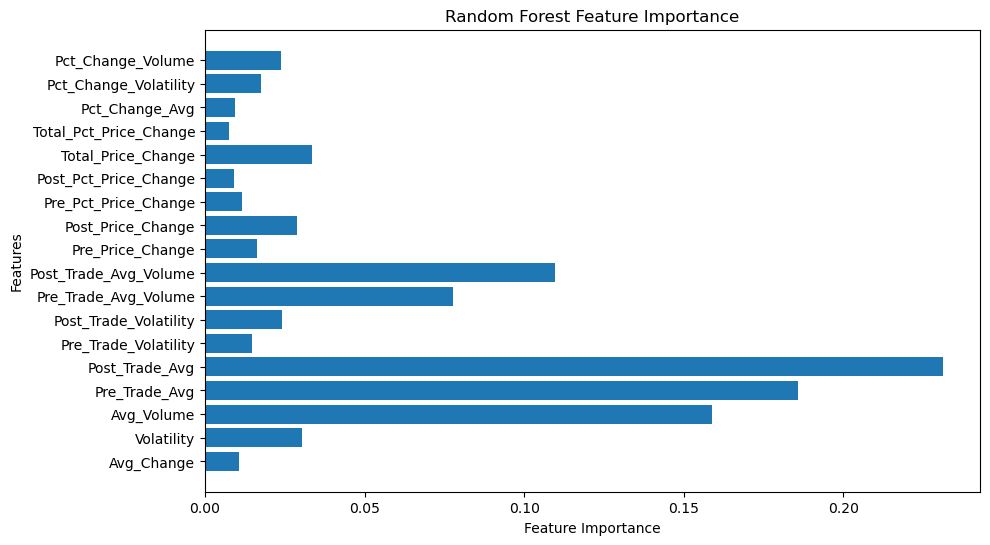

In [14]:
import matplotlib.pyplot as plt

feature_importances = model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(X.columns, feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Random Forest Feature Importance')
plt.show()


In [15]:
#overfitting test

# Initialize a list to store the features of the 50 test windows
overfitting_test_data = []

# Use a set to track selected windows to avoid duplicates
seen_windows = set()

# Generate 50 random non-overlapping windows for overfitting check
num_test_windows = 50

for _ in range(num_test_windows):
    # Randomly select a 14-day window from the stock data
    random_index = random.randint(0, len(stock_data) - 15)  # Ensure space for 14 days
    window_data = stock_data.iloc[random_index : random_index + 14]

    # Create a unique key using the window's dates to track it
    window_key = tuple(window_data['Date'].values)

    # Skip if this window has already been selected
    if window_key in seen_windows:
        print("Duplicate window detected. Skipping...")
        continue

    # Add the window to the seen set
    seen_windows.add(window_key)

    # Generate features for the selected window
    features = generate_features(window_data)
    overfitting_test_data.append(features)

# Convert the test data to a DataFrame
columns = [
    'Avg_Change', 'Volatility', 'Avg_Volume', 
    'Pre_Trade_Avg', 'Post_Trade_Avg', 
    'Pre_Trade_Volatility', 'Post_Trade_Volatility',
    'Pre_Trade_Avg_Volume', 'Post_Trade_Avg_Volume',
    'Pre_Price_Change', 'Post_Price_Change', 
    'Pre_Pct_Price_Change', 'Post_Pct_Price_Change',
    'Total_Price_Change', 'Total_Pct_Price_Change',
    'Pct_Change_Avg', 'Pct_Change_Volatility', 'Pct_Change_Volume'
]

overfitting_test_df = pd.DataFrame(overfitting_test_data, columns=columns)

# Make predictions using the trained model
predictions = model.predict(overfitting_test_df)

# Analyze the predictions
num_predicted_as_insider = np.sum(predictions)
num_predicted_as_non_insider = len(predictions) - num_predicted_as_insider

print(f"Out of 50 random non-insider windows:")
print(f"Predicted as insider trades: {num_predicted_as_insider}")
print(f"Predicted as non-insider trades: {num_predicted_as_non_insider}")

Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Duplicate window detected. Skipping...
Out of 50 random non-insider windows:
Predicted as insider trades: 3
Predicted as non-insider trades: 44


In [22]:
#------------NEW CODE FOR THE FINAL PART------------

In [17]:
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import numpy as np
import os
from imblearn.over_sampling import SMOTE

In [18]:

#load the combined dataset
df = pd.read_csv('all_features.csv')

#separate features n labels
X = df.drop('Label', axis=1)
y = df['Label']

#normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#set environment variables to control threading
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

#apply SMOTE
smote = SMOTE(random_state=42, n_jobs=1)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

#smote:
#method used to address class imbalance in datasets (this is where one class has significantly fewer samples than another,
                                                        #allowing the model to learn better from the minority class):
#does this by creating synthetic data points for the minority class
#generates new data points by interpolating between them and their nearest neighbors in the feature space, creating synthetic data that resembles the existing minority class.

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

C:\Users\swati\anaconda3\lib\site-packages\imblearn\over_sampling\_smote\base.py:336: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


Training Random Forest...
Random Forest Performance:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.88      1.00      0.94        22

    accuracy                           0.93        41
   macro avg       0.94      0.92      0.93        41
weighted avg       0.94      0.93      0.93        41

[[16  3]
 [ 0 22]]
Training XGBoost...


C:\Users\swati\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Performance:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.92      1.00      0.96        22

    accuracy                           0.95        41
   macro avg       0.96      0.95      0.95        41
weighted avg       0.96      0.95      0.95        41

[[17  2]
 [ 0 22]]
Training LSTM...


C:\Users\swati\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.4604 - loss: 0.6939 - val_accuracy: 0.7500 - val_loss: 0.6851
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6821 - loss: 0.6765 - val_accuracy: 0.6786 - val_loss: 0.6745
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6972 - loss: 0.6620 - val_accuracy: 0.6786 - val_loss: 0.6633
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7487 - loss: 0.6442 - val_accuracy: 0.6786 - val_loss: 0.6510
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7013 - loss: 0.6349 - val_accuracy: 0.6786 - val_loss: 0.6365
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6920 - loss: 0.6111 - val_accuracy: 0.6786 - val_loss: 0.6199
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7128 - loss: 0.5791 - val_accuracy: 0.6786 - val_loss: 0.6014
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.7347 - loss: 0.5478 - val_accuracy: 0.6786 - val_loss: 0.5818

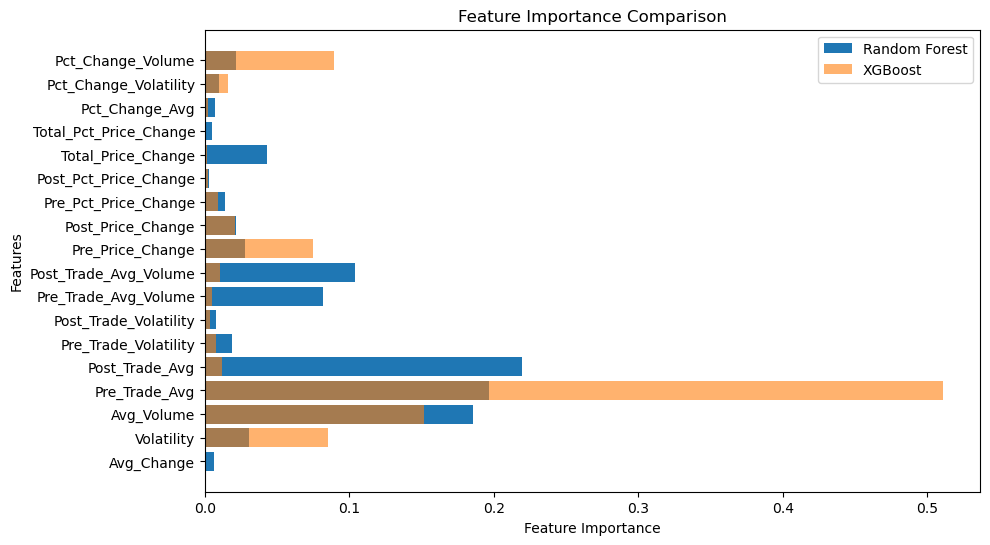

Cross-validation (Random Forest):
RF Accuracy: 0.9031
Cross-validation (XGBoost):


C:\Users\swati\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\swati\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\swati\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\swati\anaconda3\lib\site-packages\

XGBoost Accuracy: 0.8531


C:\Users\swati\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [12:44:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [19]:
#---------------------- Random Forest
print("Training Random Forest...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print("Random Forest Performance:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))

#-------------------- XGBoost
print("Training XGBoost...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
print("XGBoost Performance:")
print(classification_report(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))

#-------------------- Neural Network (LSTM)
print("Training LSTM...")
# Reshape data for LSTM: (samples, time_steps, features)
X_lstm = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

#prep labels for categorical crossentropy
y_lstm = to_categorical(y)

#split LSTM data into train/test
X_train_lstm, X_test_lstm, y_train_lstm, y_test_lstm = train_test_split(X_lstm, y_lstm, test_size=0.3, random_state=42)

#build LSTM model (diff to XGBOOST and RF)
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
lstm_model.add(Dropout(0.2))
lstm_model.add(LSTM(64, return_sequences=False))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(2, activation='softmax'))

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, validation_split=0.2, verbose=1)

#eval LSTM model
y_pred_lstm = np.argmax(lstm_model.predict(X_test_lstm), axis=1)
y_test_lstm = np.argmax(y_test_lstm, axis=1)
print("LSTM Performance:")
print(classification_report(y_test_lstm, y_pred_lstm))
print(confusion_matrix(y_test_lstm, y_pred_lstm))

#feature Importance for Random Forest and XGBoost
rf_importances = rf_model.feature_importances_
xgb_importances = xgb_model.feature_importances_

#plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(X.columns, rf_importances, label="Random Forest")
plt.barh(X.columns, xgb_importances, alpha=0.6, label="XGBoost")
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance Comparison")
plt.legend()
plt.show()

#cross-validation for Random Forest and XGBoost
print("Cross-validation (Random Forest):")
rf_scores = cross_val_score(rf_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"RF Accuracy: {rf_scores.mean():.4f}")

print("Cross-validation (XGBoost):")
xgb_scores = cross_val_score(xgb_model, X_scaled, y, cv=5, scoring='accuracy')
print(f"XGBoost Accuracy: {xgb_scores.mean():.4f}")

In [20]:
#----------------FINAL COMPARISONS---------------
#LOOOK HERE FOR WRITEUPS


Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        19
           1       0.88      1.00      0.94        22

    accuracy                           0.93        41
   macro avg       0.94      0.92      0.93        41
weighted avg       0.94      0.93      0.93        41


Random Forest Confusion Matrix:
[[16  3]
 [ 0 22]]

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.92      1.00      0.96        22

    accuracy                           0.95        41
   macro avg       0.96      0.95      0.95        41
weighted avg       0.96      0.95      0.95        41


XGBoost Confusion Matrix:
[[17  2]
 [ 0 22]]

LSTM Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.83      0.81        30
           1       0.82      0.77      0

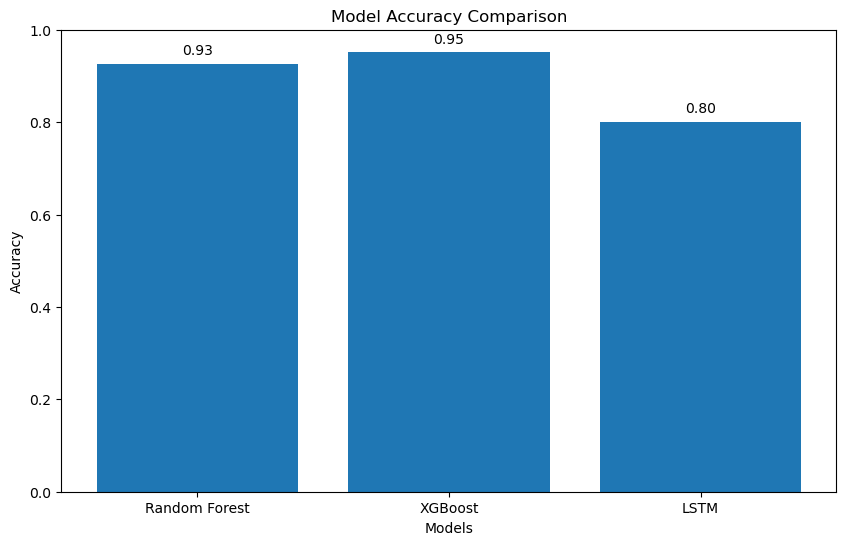

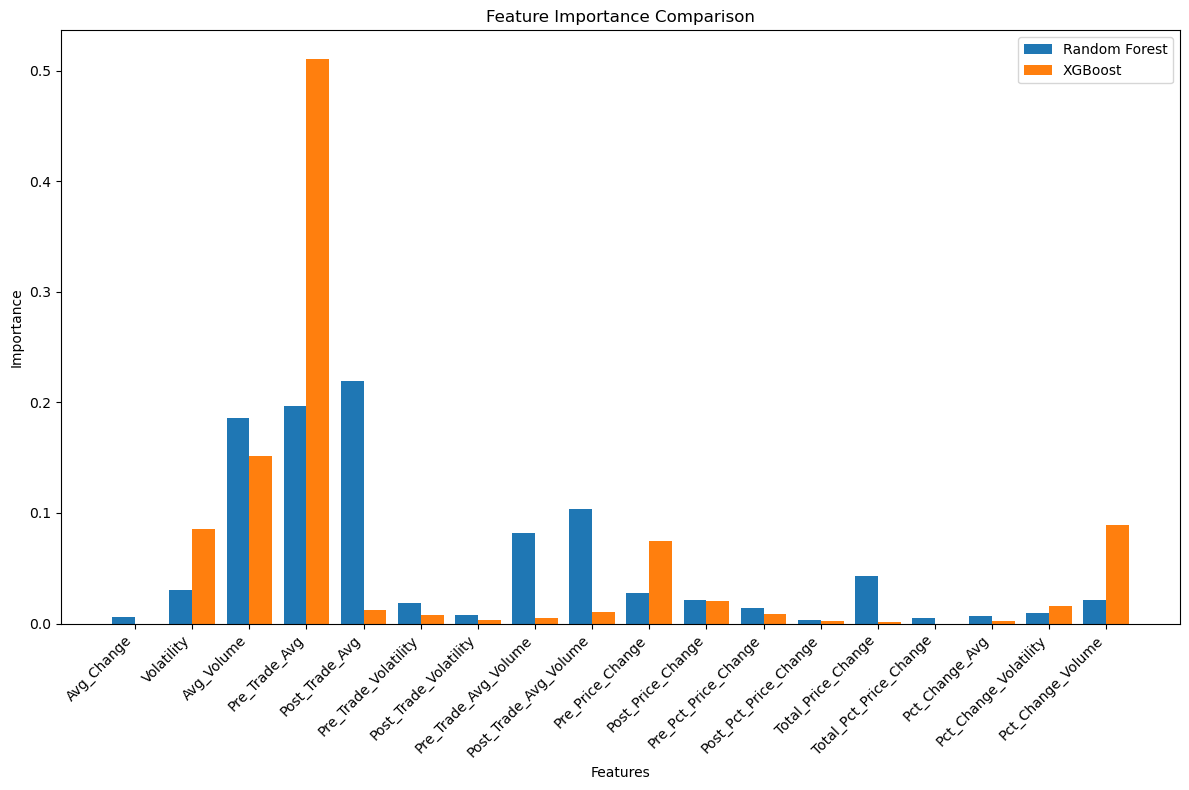

In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#store accuracy scores
accuracy_scores = {}

#calculate and print accuracy for Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
accuracy_scores['Random Forest'] = rf_accuracy
print("\nRandom Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

# calculate and print accuracy for XGBoost
xgb_accuracy = accuracy_score(y_test, y_pred_xgb)
accuracy_scores['XGBoost'] = xgb_accuracy
print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))
print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))

# calculate and print accuracy for LSTM
lstm_accuracy = accuracy_score(y_test_lstm, y_pred_lstm)
accuracy_scores['LSTM'] = lstm_accuracy
print("\nLSTM Classification Report:")
print(classification_report(y_test_lstm, y_pred_lstm))
print("\nLSTM Confusion Matrix:")
print(confusion_matrix(y_test_lstm, y_pred_lstm))

# visualize the accuracies in a bar chart
plt.figure(figsize=(10, 6))
plt.bar(accuracy_scores.keys(), accuracy_scores.values())
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.ylim(0, 1)  # Accuracies range between 0 and 1
for model, acc in accuracy_scores.items():
    plt.text(model, acc + 0.02, f'{acc:.2f}', ha='center', fontsize=10)
plt.show()

# visualize feature importance for Random Forest and XGBoost
plt.figure(figsize=(12, 8))
x_positions = np.arange(len(X.columns))

# random Forest Feature Importance
plt.bar(x_positions - 0.2, rf_model.feature_importances_, width=0.4, label='Random Forest')

# XGBoost Feature Importance
plt.bar(x_positions + 0.2, xgb_model.feature_importances_, width=0.4, label='XGBoost')

# extra formatting
plt.title('Feature Importance Comparison')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(ticks=x_positions, labels=X.columns, rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()
